In [6]:
import os
import re
import csv
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences,find_peaks_cwt
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat

In [13]:
#loading times

ASAS_times = pd.read_csv('./results/ASASJ103158-5814.7/ASASJ103158-5814.7_times.csv').times.astype('float32')
BGCru_times = pd.read_csv('./results/BGCru/BGCru_times.csv').times.astype('float32')
QZNor_times = pd.read_csv('./results/QZNor/QZNor_times.csv').times.astype('float32')
RCru_times = pd.read_csv('./results/RCru/RCru_times.csv').times.astype('float32')
V0391Nor_times = pd.read_csv('./results/V0391/V0391Nor_times.csv').times.astype('float32')
V1048Cen_times = pd.read_csv('./results/V1048Cen/V1048Cen_times.csv').times.astype('float32')
V1210Cen_times = pd.read_csv('./results/V1210Cen/V1210Cen_times.csv').times.astype('float32')
zetGem_times = pd.read_csv('./results/zetGem/zetGem_times.csv').times.astype('float32')

times = [ASAS_times,BGCru_times,QZNor_times,RCru_times,V0391Nor_times,V1048Cen_times,V1210Cen_times,zetGem_times]

In [2]:
ASAS_results = []
BGCru_results = []
QZNor_results = []
RCru_results = []
V0391_results = []
V1048Cen_results = []
V1210Cen_results = []
zetGem_results = []

for filename in os.listdir('./results/ASASJ103158-5814.7/'):
    ASAS_results.append(stat.open_csv('./results/ASASJ103158-5814.7/'+filename))
for filename in os.listdir('./results/BGCru/'):
    BGCru_results.append(stat.open_csv('./results/BGCru/'+filename))
for filename in os.listdir('./results/QZNor/'):
    QZNor_results.append(stat.open_csv('./results/QZNor/'+filename))
for filename in os.listdir('./results/RCru/'):
    RCru_results.append(stat.open_csv('./results/RCru/'+filename))
for filename in os.listdir('./results/V0391/'):
    V0391_results.append(stat.open_csv('./results/V0391/'+filename))
for filename in os.listdir('./results/V1048Cen/'):
    V1048Cen_results.append(stat.open_csv('./results/V1048Cen/'+filename))
for filename in os.listdir('./results/V1210Cen/'):
    V1210Cen_results.append(stat.open_csv('./results/V1210Cen/'+filename))
for filename in os.listdir('./results/zetGem/'):
    zetGem_results.append(stat.open_csv('./results/zetGem/'+filename))

In [14]:
pvalue = [1e-3]
p_value_levels = []
for idx, time in enumerate(times):
    pvalue_level = stat.calc_pdc_pval(time, pvalue, inverse_sf=True)
    p_value_levels.append(pvalue_level[0])

In [3]:
plt.style.use('sparta')

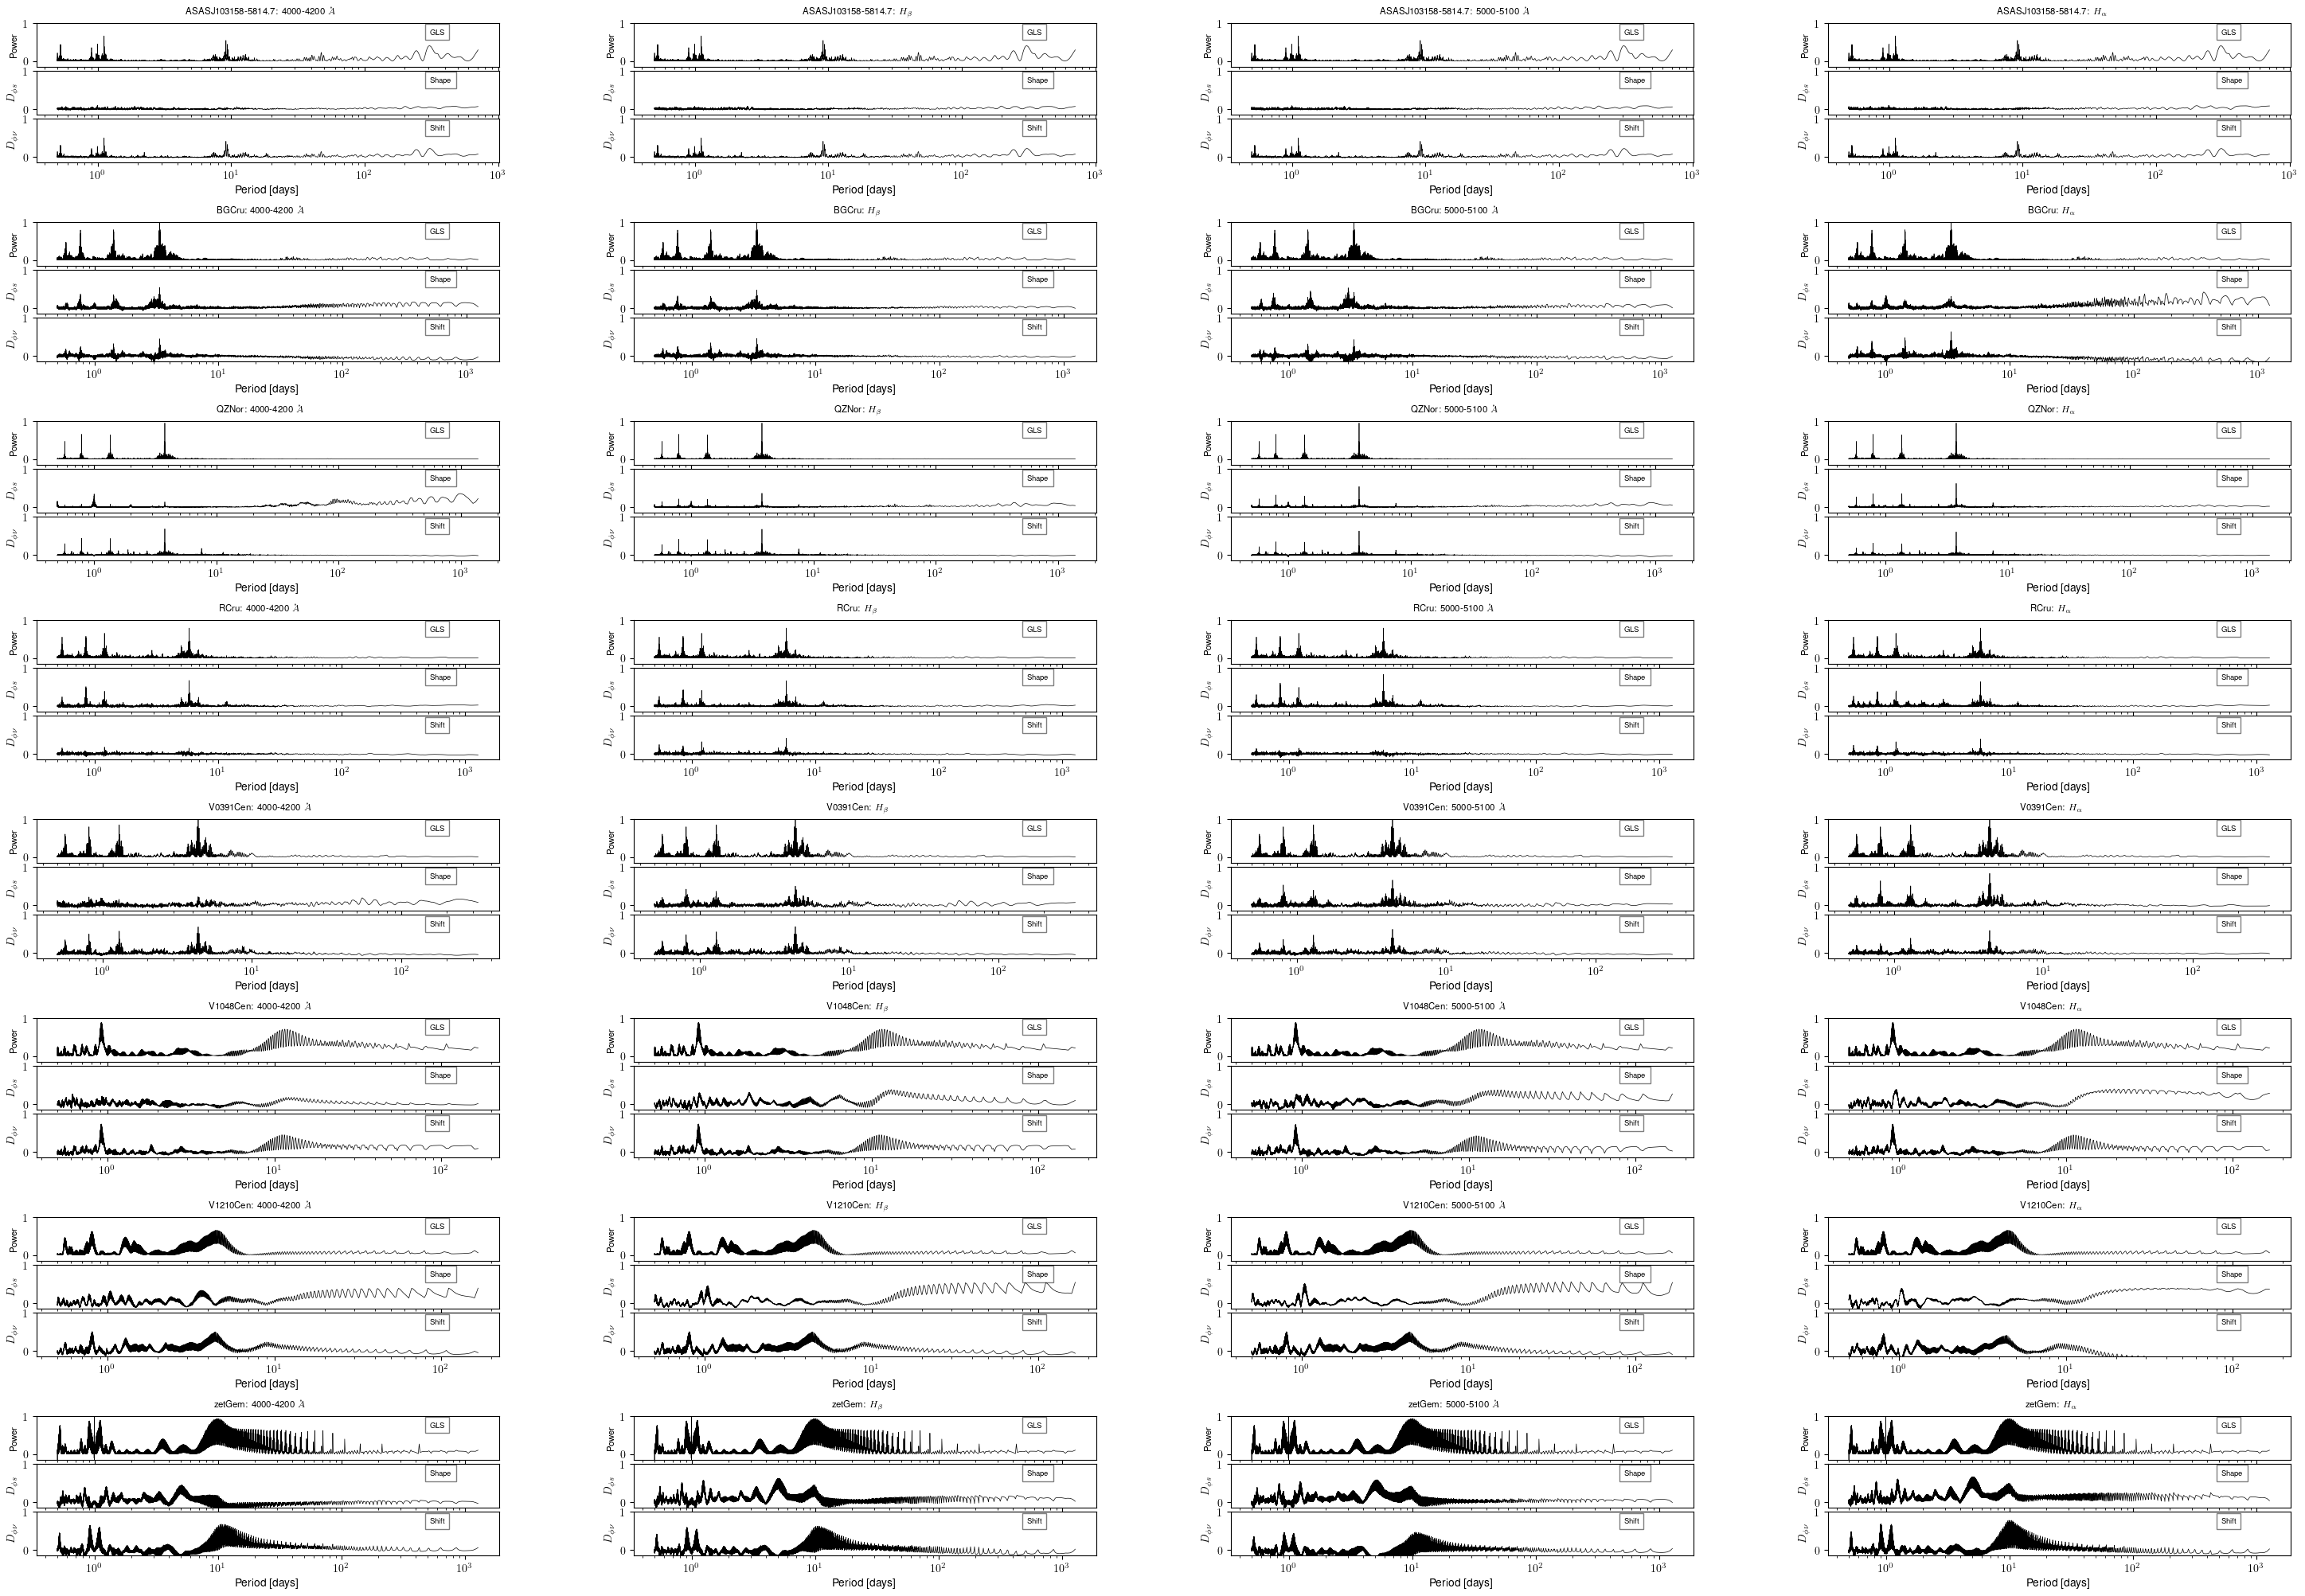

In [4]:
range_size = [r'4000-4200 $\AA$',r'$H_{\beta}$',r'5000-5100 $\AA$',r'$H_{\alpha}$']
all_results = [ASAS_results,BGCru_results, QZNor_results, RCru_results, V0391_results, V1048Cen_results,V1210Cen_results ,zetGem_results]
fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'Coralie14 stars')

subfigs = fig.subfigures(8, 4)
for outerind, subfig in enumerate(subfigs.flat):
    if 0<=outerind<=3:
        results = all_results[0]
        star = r'ASASJ103158-5814.7'
    elif 4<=outerind<=7:
        results = all_results[1]
        star = r'BGCru'
    elif 8<=outerind<=11:
        results = all_results[2]
        star = r'QZNor'
    elif 12<=outerind<=15:
        results = all_results[3]
        star = r'RCru'
    elif 16<=outerind<=19:
        results = all_results[4]
        star = r'V0391Cen'
    elif 20<=outerind<=23:
        results = all_results[5]
        star = r'V1048Cen'
    elif 24<=outerind<=27:
        results = all_results[6]
        star = r'V1210Cen'
    elif 28<=outerind<=31:
        results = all_results[7]
        star = r'zetGem'
    axs = subfig.subplots(3,1,sharex=True,sharey = True)
    subfig.suptitle(star+': ' +str(range_size[outerind%4]), fontsize='small')
    for innerind, ax in enumerate(axs.flat):
        #put semilog(x)
        if innerind==0:
            ax.plot(results[outerind%4]['period'], results[outerind%4]['gls'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            ax.plot(results[outerind%4]['period'], results[outerind%4]['shape'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi s}$')
        elif innerind==2:
            ax.plot(results[outerind%4]['period'],results[outerind%4]['shift'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi \nu}$')
            ax.set_xlabel(r'Period [days]')
        ax.set_ylim(-0.15,1)
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.85, 0.75, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),fontsize = 'x-small')
plt.subplots_adjust(top=0.9, hspace=0.1, wspace=0.2,bottom=0.2)
plt.savefig('all_coralie14.pdf')
plt.show()

In [15]:
def get_peaks(period, power, height, distance=5):
    peaks, peaks_height = find_peaks(power, height=height, distance=distance)
    peaks_period = period[peaks]
    #sort by height
    sorted_height = np.argsort(peaks_height['peak_heights'])[::-1]
    peaks_period = peaks_period[sorted_height]
    peaks_height = peaks_height['peak_heights'][sorted_height]
    return peaks_period, peaks_height
def get_main_peak(period, power, height, distance=5):
    peaks, peaks_height = find_peaks(power, height=height, distance=distance)
    peaks_period = period[peaks]
    if len(peaks_period)==0:
        return np.nan, np.nan
    #sort by height
    sorted_height = np.argsort(peaks_height['peak_heights'])[::-1]
    peaks_period = peaks_period[sorted_height]
    peaks_height = peaks_height['peak_heights'][sorted_height]
    return peaks_period[0], peaks_height[0]

In [18]:
ASAS_peaks_gls = []
ASAS_peaks_shape = []
ASAS_peaks_shift = []
for result in ASAS_results:
    ASAS_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    ASAS_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[0],distance=5))
    ASAS_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[0],distance=5))
ASAS_peaks = [ASAS_peaks_gls,ASAS_peaks_shape,ASAS_peaks_shift]

BGCru_peaks_gls = []
BGCru_peaks_shape = []
BGCru_peaks_shift = []
for result in BGCru_results:
    BGCru_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    BGCru_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[1],distance=5))
    BGCru_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[1],distance=5))
BGCru_peaks = [BGCru_peaks_gls,BGCru_peaks_shape,BGCru_peaks_shift]

QZNor_peaks_gls = []
QZNor_peaks_shape = []
QZNor_peaks_shift = []
for result in QZNor_results:
    QZNor_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    QZNor_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[2],distance=5))
    QZNor_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[2],distance=5))
QZNor_peaks = [QZNor_peaks_gls,QZNor_peaks_shape,QZNor_peaks_shift]

RCru_peaks_gls = []
RCru_peaks_shape = []
RCru_peaks_shift = []
for result in RCru_results:
    RCru_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    RCru_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[3],distance=5))
    RCru_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[3],distance=5))
RCru_peaks = [RCru_peaks_gls,RCru_peaks_shape,RCru_peaks_shift]

V0391Cen_peaks_gls = []
V0391Cen_peaks_shape = []
V0391Cen_peaks_shift = []
for result in V0391_results:
    V0391Cen_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    V0391Cen_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[4],distance=5))
    V0391Cen_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[4],distance=5))
V0391Cen_peaks = [V0391Cen_peaks_gls,V0391Cen_peaks_shape,V0391Cen_peaks_shift]

V1048Cen_peaks_gls = []
V1048Cen_peaks_shape = []
V1048Cen_peaks_shift = []
for result in V1048Cen_results:
    V1048Cen_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    V1048Cen_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[5],distance=5))
    V1048Cen_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[5],distance=5))
V1048Cen_peaks = [V1048Cen_peaks_gls,V1048Cen_peaks_shape,V1048Cen_peaks_shift]

V1210Cen_peaks_gls = []
V1210Cen_peaks_shape = []
V1210Cen_peaks_shift = []
for result in V1210Cen_results:
    V1210Cen_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    V1210Cen_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[6],distance=5))
    V1210Cen_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[6],distance=5))
V1210Cen_peaks = [V1210Cen_peaks_gls,V1210Cen_peaks_shape,V1210Cen_peaks_shift]

zetGem_peaks_gls = []
zetGem_peaks_shape = []
zetGem_peaks_shift = []
for result in zetGem_results:
    zetGem_peaks_gls.append(get_main_peak(result['period'],result['gls'],float(LombScargle(1/result['period'],result['gls']).false_alarm_level(pvalue[0], method = 'baluev')),distance=5))
    zetGem_peaks_shape.append(get_main_peak(result['period'],result['shape'],p_value_levels[7],distance=5))
    zetGem_peaks_shift.append(get_main_peak(result['period'],result['shift'],p_value_levels[7],distance=5))
zetGem_peaks = [zetGem_peaks_gls,zetGem_peaks_shape,zetGem_peaks_shift]

all_peaks = [ASAS_peaks,BGCru_peaks,QZNor_peaks,RCru_peaks,V0391Cen_peaks,V1048Cen_peaks,V1210Cen_peaks,zetGem_peaks]

In [19]:
stars = ['ASASJ103158-5814.7','BGCru','QZNor','RCru','V0391Cen','V1048Cen','V1210Cen','zetGem']
ASAS_main_peak = []
BGCru_main_peak = []
QZNor_main_peak = []
RCru_main_peak = []
V0391Cen_main_peak = []
V1048Cen_main_peak = []
V1210Cen_main_peak = []
zetGem_main_peak = []

for idx1,peaks in enumerate(all_peaks):
    for idx2,array in enumerate(peaks):
        main_peak_idx = np.argmax(array[1])
        main_peak_period = array[0][main_peak_idx]
        if idx1==0:
            ASAS_main_peak.append(main_peak_period)
        elif idx1==1:
            BGCru_main_peak.append(main_peak_period)
        elif idx1==2:
            QZNor_main_peak.append(main_peak_period)
        elif idx1==3:
            RCru_main_peak.append(main_peak_period)
        elif idx1==4:
            V0391Cen_main_peak.append(main_peak_period)
        elif idx1==5:
            V1048Cen_main_peak.append(main_peak_period)
        elif idx1==6:
            V1210Cen_main_peak.append(main_peak_period)
        elif idx1==7:
            zetGem_main_peak.append(main_peak_period)
    main_peaks = [ASAS_main_peak,BGCru_main_peak,QZNor_main_peak,RCru_main_peak,V0391Cen_main_peak,V1048Cen_main_peak,V1210Cen_main_peak,zetGem_main_peak]

    #store in a csv file
with open('Coralie14_main_peaks.csv','w',newline='',encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['star','gls','shape','shift'])
    for idx,star in enumerate(stars):
        writer.writerow([star,main_peaks[idx][0],main_peaks[idx][1],main_peaks[idx][2]])

c:\Users\kentb\miniconda3\envs\pdm\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


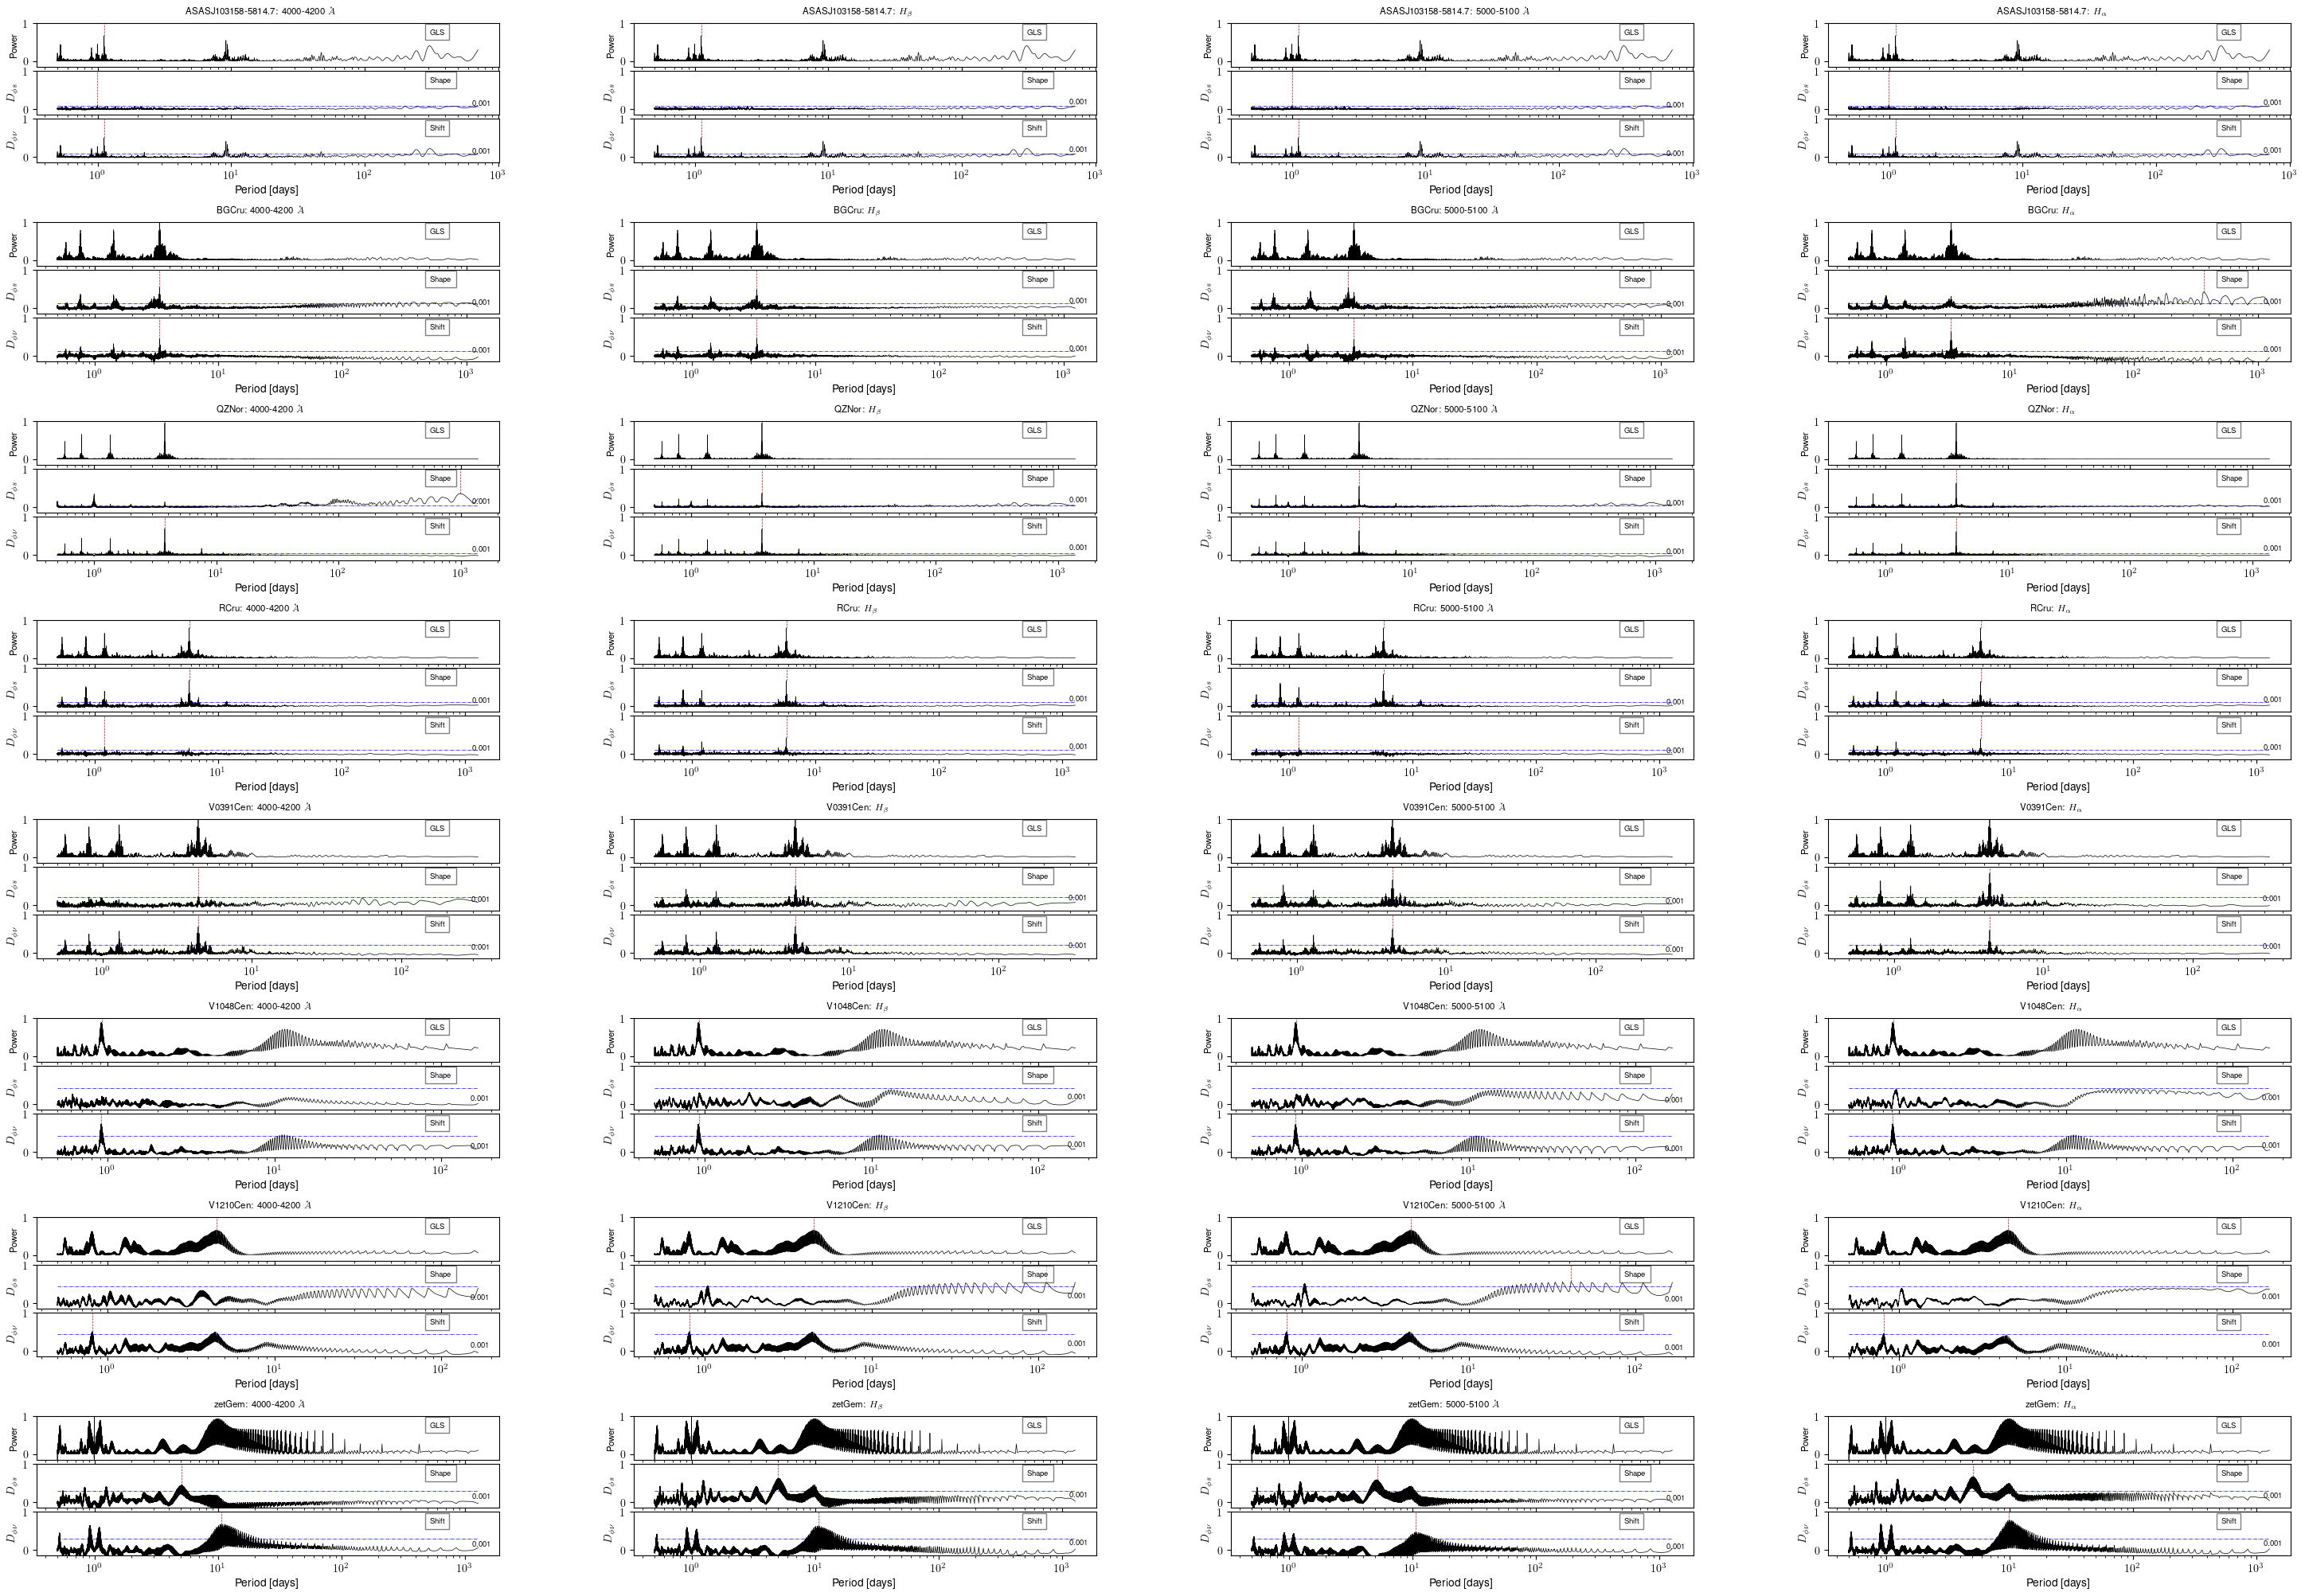

In [20]:
range_size = [r'4000-4200 $\AA$',r'$H_{\beta}$',r'5000-5100 $\AA$',r'$H_{\alpha}$']
all_results = [ASAS_results,BGCru_results, QZNor_results, RCru_results, V0391_results, V1048Cen_results,V1210Cen_results ,zetGem_results]
fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'Coralie14 stars')

subfigs = fig.subfigures(8, 4)
for outerind, subfig in enumerate(subfigs.flat):
    if 0<=outerind<=3:
        results = all_results[0]
        peaks = all_peaks[0]
        p_value_level = p_value_levels[0]
        star = r'ASASJ103158-5814.7'
    elif 4<=outerind<=7:
        results = all_results[1]
        peaks = all_peaks[1]
        p_value_level = p_value_levels[1]
        star = r'BGCru'
    elif 8<=outerind<=11:
        results = all_results[2]
        peaks = all_peaks[2]
        p_value_level = p_value_levels[2]
        star = r'QZNor'
    elif 12<=outerind<=15:
        results = all_results[3]
        peaks = all_peaks[3]
        p_value_level = p_value_levels[3]
        star = r'RCru'
    elif 16<=outerind<=19:
        results = all_results[4]
        peaks = all_peaks[4]
        p_value_level = p_value_levels[4]
        star = r'V0391Cen'
    elif 20<=outerind<=23:
        results = all_results[5]
        peaks = all_peaks[5]
        p_value_level = p_value_levels[5]
        star = r'V1048Cen'
    elif 24<=outerind<=27:
        results = all_results[6]
        peaks = all_peaks[6]
        p_value_level = p_value_levels[6]
        star = r'V1210Cen'
    elif 28<=outerind<=31:
        results = all_results[7]
        peaks = all_peaks[7]
        p_value_level = p_value_levels[7]
        star = r'zetGem'
    axs = subfig.subplots(3,1,sharex=True,sharey = True)
    subfig.suptitle(star+': ' +str(range_size[outerind%4]), fontsize='small')
    for innerind, ax in enumerate(axs.flat):
        #put semilog(x)
        if innerind==0:
            peaks_gls = peaks[0]
            ax.vlines(peaks_gls[outerind%4][0],peaks_gls[outerind%4][1],1,'r',ls='--',linewidth=0.5)
            ax.plot(results[outerind%4]['period'], results[outerind%4]['gls'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            peaks_shape = peaks[1]
            ax.vlines(peaks_shape[outerind%4][0],peaks_shape[outerind%4][1],1,'r',ls='--',linewidth=0.5)
            ax.hlines(p_value_level,min(results[outerind%4]['period']),max(results[outerind%4]['period']),'blue',ls='-.',linewidth=0.5)
            ax.text(max(results[outerind%4]['period'])-0.1*max(results[outerind%4]['period']),p_value_levels[outerind%4]+0.02,str(pvalue[0]),fontsize='x-small')
            ax.plot(results[outerind%4]['period'], results[outerind%4]['shape'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi s}$')
        elif innerind==2:
            peaks_shift = peaks[2]
            ax.vlines(peaks_shift[outerind%4][0],peaks_shift[outerind%4][1],1,'r',ls='--',linewidth=0.5)
            ax.hlines(p_value_level,min(results[outerind%4]['period']),max(results[outerind%4]['period']),'blue',ls='-.',linewidth=0.5)
            ax.text(max(results[outerind%4]['period'])-0.1*max(results[outerind%4]['period']),p_value_levels[outerind%4]+0.02,str(pvalue[0]),fontsize='x-small')
            ax.plot(results[outerind%4]['period'],results[outerind%4]['shift'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi \nu}$')
            ax.set_xlabel(r'Period [days]')
        ax.set_ylim(-0.15,1)
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.85, 0.75, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),fontsize = 'x-small')
plt.subplots_adjust(top=0.9, hspace=0.1, wspace=0.2,bottom=0.2)
plt.savefig('all_coralie14_peaks.pdf')
plt.show()

In [25]:
# get per wv range
stars = ['ASASJ103158-5814.7','BGCru','QZNor','RCru','V0391Cen','V1048Cen','V1210Cen','zetGem']
range_size = ['4000_4200','Hbeta','5000_5100','Halpha']
all_peaks = [ASAS_peaks,BGCru_peaks,QZNor_peaks,RCru_peaks,V0391Cen_peaks,V1048Cen_peaks,V1210Cen_peaks,zetGem_peaks]
#get main peaks
ASAS_main_peak = []
BGCru_main_peak = []
QZNor_main_peak = []
RCru_main_peak = []
V0391Cen_main_peak = []
V1048Cen_main_peak = []
V1210Cen_main_peak = []
zetGem_main_peak = []

for idx0, range in enumerate(range_size):
    filename = 'Coralie14_main_peaks_'+range+'.csv'
    for idx1,star_peaks in enumerate(all_peaks):
        for idx2, periodogram in enumerate(star_peaks):
            if idx1==0:
                ASAS_main_peak.append(periodogram[idx0][0])
            elif idx1==1:
                BGCru_main_peak.append(periodogram[idx0][0])
            elif idx1==2:
                QZNor_main_peak.append(periodogram[idx0][0])
            elif idx1==3:
                RCru_main_peak.append(periodogram[idx0][0])
            elif idx1==4:
                V0391Cen_main_peak.append(periodogram[idx0][0])
            elif idx1==5:
                V1048Cen_main_peak.append(periodogram[idx0][0])
            elif idx1==6:
                V1210Cen_main_peak.append(periodogram[idx0][0])
            elif idx1==7:
                zetGem_main_peak.append(periodogram[idx0][0])
    main_peaks = [ASAS_main_peak,BGCru_main_peak,QZNor_main_peak,RCru_main_peak,V0391Cen_main_peak,V1048Cen_main_peak,V1210Cen_main_peak,zetGem_main_peak]
    with open(filename,'w',newline='',encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['star','gls','shape','shift'])
        for idx,star in enumerate(stars):
            writer.writerow([star,main_peaks[idx][3*idx0],main_peaks[idx][3*idx0+1],main_peaks[idx][3*idx0+2]])
print(main_peaks[1])


[3.3423978622264165, 3.3428467472468606, 3.3423978622264165, 3.3423978622264165, 3.3428467472468606, 3.3423978622264165, 3.3423978622264165, 3.0083196615905394, 3.3423978622264165, 3.3423978622264165, 366.04171882353126, 3.3423978622264165]
